In [3]:
%run -i src/segmentello/u_net_eval.py

loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

<Figure size 1600x2000 with 0 Axes>

# ignore

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


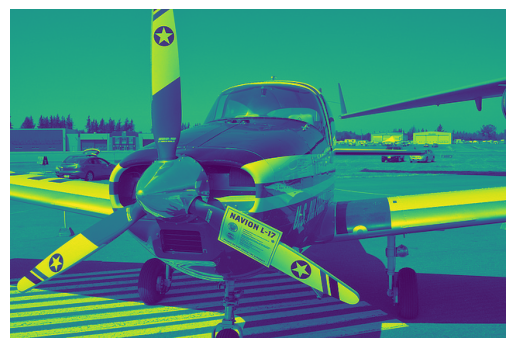

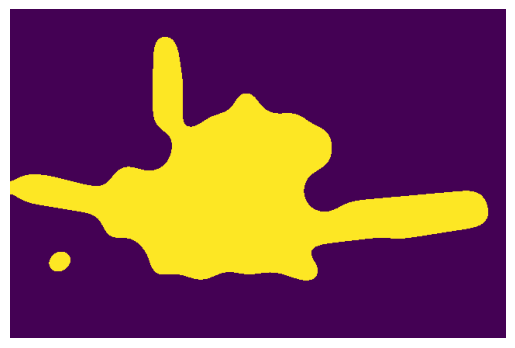

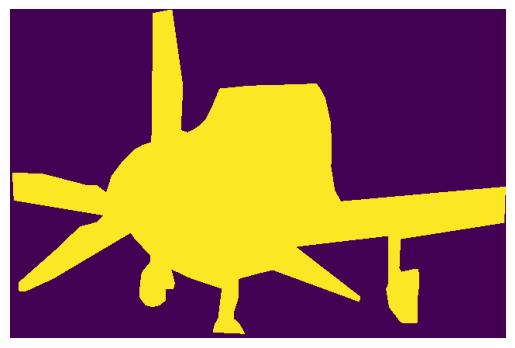

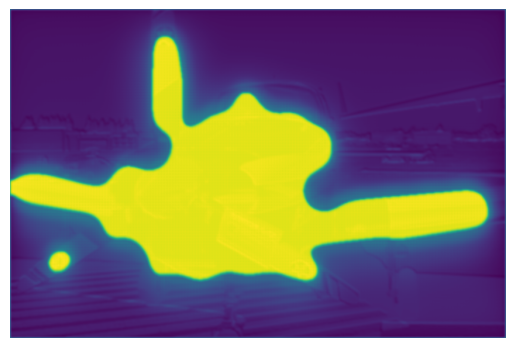

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import numpy as np
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning import Trainer


data_dir = './COCO_dset_adaptation/reduced_dset'

# === Paths ===
ann_file = os.path.join(data_dir, 'annotations', 'instances_train2014.json')
img_dir = os.path.join(data_dir, 'train2014')

# === Load COCO ===
coco = COCO(ann_file)


def random_coarse(mask):
    # Convert to uint8 and ensure contiguous
    mask = np.ascontiguousarray((mask * 255).astype(np.uint8))

    # Step 1: Generate a band around the edge
    contour_band = cv2.dilate(mask, np.ones((7, 7), np.uint8), iterations=1)
    contour_band = cv2.subtract(contour_band, mask)

    # Get coordinates where noise can be placed (in edge band)
    edge_coords = np.column_stack(np.where(contour_band > 0))

    noise = np.zeros_like(mask, dtype=np.uint8)

    # Add random circles only around the contour area
    num_circles = random.randint(15, 40)
    for _ in range(num_circles):
        if len(edge_coords) == 0:
            break
        y, x = edge_coords[random.randint(0, len(edge_coords) - 1)]
        radius = random.randint(3, 10)
        cv2.circle(noise, (x, y), radius, 255, -1)

    # Combine noise with original mask
    mask = cv2.bitwise_or(mask, noise)

    # Step 2: Random dilation
    dilate_kernel_size = random.randint(7, 15)
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate_kernel_size, dilate_kernel_size))
    mask = cv2.dilate(mask, kernel_dilate, iterations=random.randint(1, 2))

    # Step 3: Random erosion
    erode_kernel_size = random.randint(5, dilate_kernel_size - 1)
    kernel_erode = cv2.getStructuringElement(random.choice([
        cv2.MORPH_ELLIPSE, cv2.MORPH_RECT, cv2.MORPH_CROSS
    ]), (erode_kernel_size, erode_kernel_size))
    mask = cv2.erode(mask, kernel_erode, iterations=1)

    # Step 4: Gaussian blur + threshold for soft borders
    blur = cv2.GaussianBlur(mask, (5, 5), sigmaX=random.uniform(2.0, 4.5))
    _, coarse_mask = cv2.threshold(blur, random.randint(60, 120), 1, cv2.THRESH_BINARY)

    return coarse_mask.astype(np.uint8)


def random_coarse_v2(mask):
    mask = np.ascontiguousarray((mask > 0).astype(np.uint8) * 255)

    band_width   = random.randint(15, 40)                      
    contour_band = cv2.dilate(mask,
                              cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                                        (band_width, band_width)),
                              iterations=1)
    contour_band = cv2.subtract(contour_band, mask)
    edge_coords  = np.column_stack(np.where(contour_band > 0))

    noise = np.zeros_like(mask, np.uint8)
    num_circles = random.randint(8, 18)                        
    for _ in range(num_circles):
        y, x = edge_coords[random.randrange(len(edge_coords))]
        radius = random.randint(band_width//2, band_width)     
        cv2.circle(noise, (x, y), radius, 255, -1)

    mask = cv2.bitwise_or(mask, noise)

    close_size = random.randint(band_width//2, band_width)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                             (close_size, close_size))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close)

    blur = cv2.GaussianBlur(mask, (0, 0), sigmaX=random.uniform(6.0, 12.0)) 
    _, coarse = cv2.threshold(blur, 127, 1, cv2.THRESH_BINARY)

    return coarse.astype(np.uint8)


def random_coarse_v2(mask):
    """
    erode
    """
    mask = np.ascontiguousarray((mask > 0).astype(np.uint8) * 255)

    band_width = random.randint(15, 40)                       
    contour_band = cv2.erode(mask,
                              cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                                        (band_width, band_width)),
                              iterations=1)
    contour_band = cv2.subtract(mask, contour_band)
    edge_coords = np.column_stack(np.where(contour_band > 0))

    noise = np.zeros_like(mask, np.uint8)
    num_circles = random.randint(8, 18)                       
    for _ in range(num_circles):
        y, x = edge_coords[random.randrange(len(edge_coords))]
        radius = random.randint(band_width // 2, band_width)  
        cv2.circle(noise, (x, y), radius, 255, -1)

    mask = cv2.bitwise_and(mask, cv2.bitwise_not(noise))

    open_size = random.randint(band_width // 2, band_width)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                             (open_size, open_size))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_open)

    blur = cv2.GaussianBlur(mask, (0, 0), sigmaX=random.uniform(6.0, 12.0))  
    _, coarse = cv2.threshold(blur, 127, 1, cv2.THRESH_BINARY)

    return coarse.astype(np.uint8)


def random_coarse_distanza(mask, sigma_noise=12, blur_sigma=6.0, bias=12):

    mask = (mask > 0).astype(np.uint8)

    d_in  = cv2.distanceTransform(mask,  cv2.DIST_L2, 3)
    d_out = cv2.distanceTransform(1-mask, cv2.DIST_L2, 3)
    signed = d_in - d_out                 

    noise = np.random.randn(*mask.shape).astype(np.float32)
    noise = cv2.GaussianBlur(noise, (0,0), blur_sigma)

    d_hat = signed + sigma_noise * noise - bias
    coarse = (d_hat > 0).astype(np.uint8)

    return coarse


class CoarseMaskDataset(Dataset):
    def __init__(
        self, 
        dataset_dir: str, 
        transform_type: str = "v2", 
        mode: str = "gray",
        max_masks: int | None = None,
    ):
        self.img_dir = os.path.join(dataset_dir, 'train2014')
        self.ann_file = os.path.join(dataset_dir, 'annotations', 'instances_train2014.json')
        self.transform_type = transform_type
        self.coco = COCO(self.ann_file)
        self.mode = mode  # "gray", "rgb"
        self.max_masks = max_masks
        all_ids = list(self.coco.imgs.keys())
        self.ids = [img_id for img_id in all_ids if len(self.coco.getAnnIds(imgIds=img_id)) > 0]


    def __len__(self):
        return len(self.ids)

    
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info["file_name"])

        # Load and convert image
        if self.mode == "gray":
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
        elif self.mode == "rgb":
            image = cv2.imread(img_path)
            image = image[:,:,::-1]  # FIXME
        else:
            raise ValueError("wrong mode")
        
        # Load annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        if not anns:
            raise ValueError(f"No annotations found for image id {img_id}")

        # Seleziona annotazioni
        if self.max_masks is None or self.max_masks == 1:
            # Prende la migliore annotazione (quella con area massima)
            best_ann = max(anns, key=lambda ann: ann['area'])
            selected_anns = [best_ann]
        else:
            selected_anns = sorted(anns, key=lambda ann: ann['area'], reverse=True)[:self.max_masks]

        # Crea maschera GT
        gt_mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in selected_anns:
            gt_mask += self.coco.annToMask(ann)

        gt_mask = np.clip(gt_mask, 0, 1)

        # # Crea coarse mask
        # if self.coarse_mask_fn is not None:
        #     coarse_mask = self.coarse_mask_fn(gt_mask)
        # else:
        #     coarse_mask = gt_mask.copy()
        
        if self.transform_type == "v1":
            coarse_mask = random_coarse(gt_mask)
        elif self.transform_type == "v2":
            coarse_mask = random_coarse_v2(gt_mask)
        elif self.transform_type == "dist":
            coarse_mask = random_coarse_distanza(gt_mask)
        else:
            raise ValueError("Unknown transform type")

        # # Applica transform
        # if self.transform is not None:
        #     image = self.transform(image)
        #     gt_mask = torch.from_numpy(gt_mask).unsqueeze(0).float()
        #     coarse_mask = torch.from_numpy(coarse_mask).unsqueeze(0).float()
        # else:
        #     image = T.ToTensor()(image)
        #     gt_mask = torch.from_numpy(gt_mask).unsqueeze(0).float()
        #     coarse_mask = torch.from_numpy(coarse_mask).unsqueeze(0).float()

        image = T.ToTensor()(image)
        gt_mask = torch.from_numpy(gt_mask).unsqueeze(0).float()
        coarse_mask = torch.from_numpy(coarse_mask).unsqueeze(0).float()

        # Input = immagine + coarse mask
        input_tensor = torch.cat([image, coarse_mask], dim=0)

        return input_tensor, gt_mask


dataset_gray = CoarseMaskDataset(data_dir, transform_type="v2")
gray_dl = DataLoader(dataset_gray, batch_size=1, shuffle=True)  # batch_size=1 per immagini variabili



class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class AttentionBlock(nn.Module):
    def __init__(self, g_channels, x_channels, intermediate_channels):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(g_channels, intermediate_channels, kernel_size=1),
            nn.BatchNorm2d(intermediate_channels)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(x_channels, intermediate_channels, kernel_size=1),
            nn.BatchNorm2d(intermediate_channels)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(intermediate_channels, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)

        # Align shapes explicitly
        if g1.shape[2:] != x1.shape[2:]:
            g1 = F.interpolate(g1, size=x1.shape[2:], mode='bilinear', align_corners=False)

        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi



class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)
        self.attentions = nn.ModuleList()

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, 2, 2))
            self.ups.append(DoubleConv(feature*2, feature))
            self.attentions.append(AttentionBlock(g_channels=feature, x_channels=feature, intermediate_channels=feature//2))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, 1)

    def forward(self, x):
        skip = []
        for down in self.downs:
            x = down(x)
            skip.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip = skip[::-1]

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)  # Upsample first
            attn = self.attentions[i//2](g=x, x=skip[i//2])  # Apply attention AFTER upsample
            if x.shape != attn.shape:
                x = F.interpolate(x, size=attn.shape[2:])
            x = torch.cat([attn, x], dim=1)
            x = self.ups[i+1](x)


        return self.final_conv(x)


class DiceLoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice


class Coarse2FineUNet(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.model = UNet(in_channels=2, out_channels=1)
        # self.loss_fn = nn.BCEWithLogitsLoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.lr = lr

    def forward(self, x):
        return self.model(x)


    def training_step(self, batch, batch_idx):
        x_list, y_list = batch
        losses = []
        for x, y in zip(x_list, y_list):
            x = x.unsqueeze(0).to(self.device)
            y = y.unsqueeze(0).to(self.device)
            logits = self(x)
            bce_loss = self.bce(logits, y)
            dice_loss = self.dice(logits, y)
            loss = 0.5 * bce_loss + 0.5 * dice_loss
            losses.append(loss)
        total_loss = torch.stack(losses).mean()
        self.log("train_loss", total_loss, prog_bar=True)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)



# model = Coarse2FineUNet()
# trainer = Trainer(max_epochs=10, accelerator="gpu" if torch.cuda.is_available() else "cpu", log_every_n_steps=1)
# trainer.fit(model, gray_dl)

p = "/home/iacopo/Documenti/GitHub/NeuralTrasferello/lightning_logs/version_0/checkpoints/epoch=9-step=490.ckpt"
p = "/home/iacopo/Documenti/GitHub/NeuralTrasferello/lightning_logs/version_1/checkpoints/epoch=9-step=490.ckpt"
model = Coarse2FineUNet.load_from_checkpoint(p)

model.eval()

sample = dataset_gray[25]
item = sample[0]
target = sample[1]

with torch.no_grad():
    predicted = model(item.unsqueeze(0))

    plt.imshow(item[0])
    plt.axis("off")
    plt.show()

    plt.imshow(item[1])
    plt.axis("off")
    plt.show()

    plt.imshow(target[0])
    plt.axis("off")
    plt.show()

    plt.imshow(predicted[0][0])
    plt.axis("off")
    plt.show()

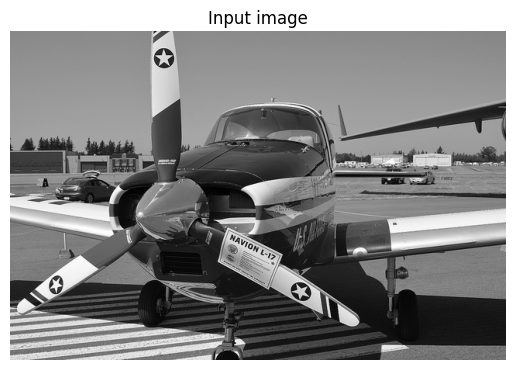

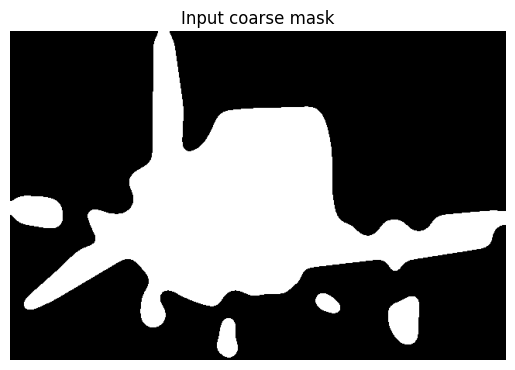

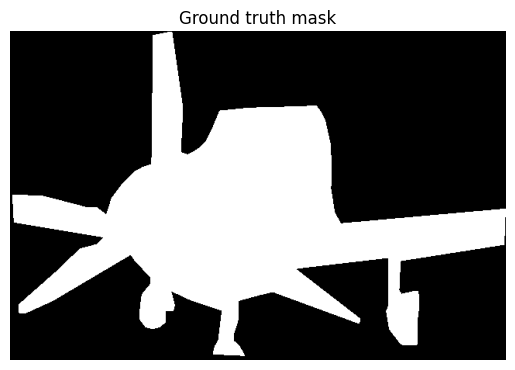

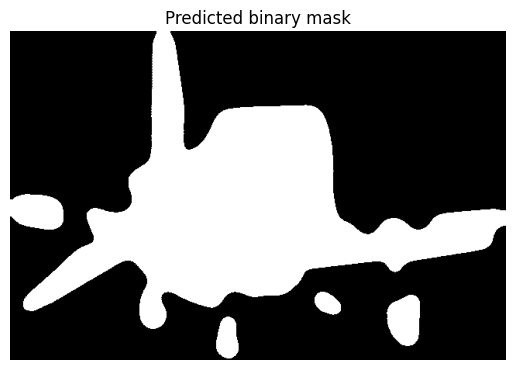

In [12]:
with torch.no_grad():
    predicted = model(item.unsqueeze(0))  # logits
    predicted_probs = torch.sigmoid(predicted)  # valori tra 0 e 1
    predicted_mask = (predicted_probs > 0.5).float()  # maschera binaria 0 o 1

    plt.imshow(item[0], cmap='gray')
    plt.title("Input image")
    plt.axis("off")
    plt.show()

    plt.imshow(item[1], cmap='gray')
    plt.title("Input coarse mask")
    plt.axis("off")
    plt.show()

    plt.imshow(target[0], cmap='gray')
    plt.title("Ground truth mask")
    plt.axis("off")
    plt.show()

    plt.imshow(predicted_mask[0][0].cpu(), cmap='gray')
    plt.title("Predicted binary mask")
    plt.axis("off")
    plt.show()
